<a href="https://colab.research.google.com/github/buoi/conditional-face-GAN/blob/main/evaluate_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ⚙️ Setup

## Fix random seeds

In [1]:
SEED = 11
import os
os.environ['PYTHONHASHSEED']=str(SEED)
import random
import numpy as np
import tensorflow as tf

random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)


## Automatic Mixed Precision
if supported by GPU

In [2]:
_, gpu_name  = !nvidia-smi --query-gpu=gpu_name --format=csv

if gpu_name == 'Tesla T4':
    from tensorflow.keras import mixed_precision

    policy = mixed_precision.Policy('mixed_float16')
    mixed_precision.set_global_policy(policy)

!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-6f316589-fd9e-5fff-b9ea-b946a2755d59)


## Imports

In [3]:
from scipy import linalg
import matplotlib.pyplot as plt
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from keras.applications.inception_v3 import InceptionV3, preprocess_input

from tensorflow.keras.layers import Layer, Input, Dense, Reshape, Flatten
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, ReLU, LeakyReLU
from tensorflow.keras.layers import Dropout, Embedding, Concatenate, Add, Activation
from tensorflow.keras.layers import GlobalAveragePooling2D, UpSampling2D, BatchNormalization
import tensorflow.keras.backend as K

from tensorflow.python.keras.utils import conv_utils
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.optimizers import Adam

!pip install tensorflow_addons
import tensorflow_addons as tfa
from tensorflow_addons.layers import SpectralNormalization

import gdown
from zipfile import ZipFile

from tqdm.notebook import tqdm

     |████████████████████████████████| 1.1 MB 8.6 MB/s 


## Download CelebA

We'll use face images from the CelebA dataset, resized to 64x64.

In [4]:
try:
    os.makedirs("celeba_gan")
    url = "https://drive.google.com/uc?id=1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684"
    output = "celeba_gan/img_align_celeba.zip"
    gdown.download(url, output, quiet=True)

    with ZipFile("celeba_gan/img_align_celeba.zip", "r") as zipobj:
        zipobj.extractall("celeba_gan")
        
except FileExistsError:
    print("Dataset Already downloaded")


In [5]:
#Download labels from public github, they have been processed in a 0,1 csv file
!wget -q -O "/content/celeba_gan/list_attr_celeba01.csv.zip" "https://github.com/buoi/conditional-face-GAN/blob/main/list_attr_celeba01.csv.zip?raw=true" 
!unzip -o "/content/celeba_gan/list_attr_celeba01.csv.zip" -d "/content/celeba_gan"

Archive:  /content/celeba_gan/list_attr_celeba01.csv.zip
  inflating: /content/celeba_gan/list_attr_celeba01.csv  
  inflating: /content/celeba_gan/__MACOSX/._list_attr_celeba01.csv  


## Dataset preprocessing functions

In [6]:
# image utils functions

def conv_range(in_range=(-1,1), out_range=(0,255)):
    """ Returns range conversion function"""

    # compute means and spans once
    in_mean, out_mean = np.mean(in_range), np.mean(out_range)
    in_span, out_span = np.ptp(in_range), np.ptp(out_range)

    # return function
    def convert_img_range(in_img):
        out_img = (in_img - in_mean) / in_span
        out_img = out_img * out_span + out_mean
        return out_img

    return convert_img_range

def crop128(img):
    #return img[:, 77:141, 57:121]# 64,64 center crop
    return img[:, 45:173, 25:153] # 128,128 center crop

def resize64(img):
    return tf.image.resize(img, (64,64), antialias=True, method='bilinear')

## FID utilities

In [33]:
#fid real images embeddings
inception_model = InceptionV3(include_top=False, 
                              weights="imagenet", 
                              pooling='avg',
                              input_shape=(299, 299, 3))
inception_model.trainable = False


def define_real_prep():
    img = layers.Input(shape=IMAGE_SHAPE, name='img_input')
    img_up = tf.image.resize(img, (299, 299), method='bilinear', antialias=True, name='upsample_bilinear')
    output = inception_model(img_up, training=False)
    real_prep = tf.keras.Model(inputs=[img], outputs=[output])

    return real_prep

def generate_dataset_embeddings(dataset, fid_count=10000):

    #tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
    real_prep = define_real_prep()
    #tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.WARN)

    real_embeddings = np.zeros((FID_COUNT, 2048), dtype='float32')
    real_attr = np.zeros((FID_COUNT, N_ATTRIBUTES), dtype='float32')

    fid_bs = 200
    assert fid_count%fid_bs ==0, 'bad fid batch size or fid_count'
    dataset = dataset.unbatch().batch(fid_bs)
    dataset.shuffle(210000)

    for i in tqdm(range(fid_count//fid_bs)):
        if N_ATTRIBUTES !=0:
            batch_img, batch_attr = next(iter(dataset))
            real_attr[i*fid_bs:(i+1)*fid_bs] = batch_attr
        else:
            batch_img = next(iter(dataset))

        batch_embeddings = real_prep(batch_img)
        real_embeddings[i*fid_bs:(i+1)*fid_bs] = batch_embeddings

    return real_embeddings, real_attr


def generate_fid_embeddings(model, real_attr, fid_count=10000, use_attributes=False):


    #tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
    if N_ATTRIBUTES !=0 and use_attributes:
        multi_evaluator = define_evaluator(model.generator, attribute_classifier)
    else:
        multi_evaluator = define_evaluator(model.generator) #1
    #tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.WARN)
    
    gen_size = 100
    assert fid_count % gen_size == 0, "wrong gen_size or fid_count"

    generated_embeddings = np.zeros((fid_count, 2048), dtype='float32') #2
    pred_attr = np.zeros((fid_count, N_ATTRIBUTES), dtype='float32')

    for i in tqdm(range(fid_count//gen_size)):
        if N_ATTRIBUTES !=0 and use_attributes:
            batch_embeddings, batch_attr = multi_evaluator((
                tf.random.normal([gen_size, LATENT_DIM]),
                real_attr[i*gen_size:(i+1)*gen_size]))
            pred_attr[i*gen_size:(i+1)*gen_size] = batch_attr
            
        elif N_ATTRIBUTES !=0: # call model with attributes but returns embeddings only #3
            batch_embeddings = multi_evaluator((
                tf.random.normal([gen_size, LATENT_DIM]),
                real_attr[i*gen_size:(i+1)*gen_size]))
        else:
            batch_embeddings = multi_evaluator(
                tf.random.normal([gen_size, LATENT_DIM]))
            
        generated_embeddings[i*gen_size:(i+1)*gen_size] = batch_embeddings

    return generated_embeddings, pred_attr

def define_evaluator(generator, attr_classifier=None):
    
    z_input = layers.Input(shape=(LATENT_DIM), name='z_input')
    attr_input = layers.Input(shape=(N_ATTRIBUTES), name='attr_input')

    img = generator((z_input,attr_input))

    img_up299 = tf.image.resize(img, (299, 299), method='bilinear', antialias=True, name='upsample_bilinear')
    output_repr = inception_model(img_up299, training=False,)

    if N_ATTRIBUTES !=0 and attr_classifier is not None:
        print("using classifier")
        attributes = attr_classifier(img) # mobilenet model does resizing.. does *2-1 also...
        multi_evaluator = tf.keras.Model(inputs=[z_input,attr_input], outputs=[output_repr, attributes])
    else:
        multi_evaluator = tf.keras.Model(inputs=[z_input,attr_input], outputs=output_repr)

    return multi_evaluator

"""def define_evaluator(generator, attr_classifier=None):
    
    img = generator.output

    img_up229 = tf.image.resize(img, (299, 299), method='bilinear', antialias=True, name='upsample_bilinear')
    output_repr = inception_model(img_up229, training=False,)

    if N_ATTRIBUTES !=0 and attr_classifier is not None:
        print("using classifier")
        attributes = attr_classifier(img) # mobilenet model does resizing.. does *2-1 also...
        multi_evaluator = tf.keras.Model(inputs=generator.inputs, outputs=[output_repr, attributes])
    else:
        multi_evaluator = tf.keras.Model(inputs=generator.inputs, outputs=output_repr)

    return multi_evaluator"""


def compute_fid(real_embeddings, generated_embeddings):
    # compute mean and covariance statistics
    print("computing FID on:",real_embeddings.shape, generated_embeddings.shape)
    mu1, sigma1 = real_embeddings.mean(axis=0), np.cov(real_embeddings, rowvar=False)
    mu2, sigma2 = generated_embeddings.mean(axis=0), np.cov(generated_embeddings, rowvar=False)
    # compute sum squared difference between means
    ssdiff = np.sum((mu1 - mu2)**2.0)
    # compute sqrt of product between cov
    covmean = linalg.sqrtm(sigma1.dot(sigma2))
    # check and correct imaginary numbers from sqrt
    if np.iscomplexobj(covmean):
      covmean = covmean.real
    # compute fid score
    trace = np.trace(sigma1 + sigma2 - 2.0 * covmean)
    fid = ssdiff + trace
    print("fid:",fid, "ssdiff:",ssdiff, "trace:",trace)
    return fid

# 📉 Evaluate model

## Load trained GAN

In [ ]:
#rn8xslip acgan2_BNstdev v22
#weighted v22
{'acc': 0.9295, 'f1': 0.91828537, 'fid': 29.05019775559193}

#3ja6uvac acgan10_nonseparBNstdev_split v24
#weighted v22
{'acc': 0.85925, 'f1': 0.7849446, 'fid': 26.88634217864331}
{'acc': 0.8578, 'f1': 0.7829237, 'fid': 26.905994087828933}

#weighted v15
{'acc': 0.85221, 'f1': 0.77358824, 'fid': 27.8183414299638}

#2ev65fpt acgan40_BNstdev v15 
#weighted
{'acc': 0.84163505,'f1': 0.42956448, 'fid': 28.225658760268864}
#weights average on range 15-25
#it works!
{'acc': 0.85081506, 'f1': 0.4661962, 'fid': 27.718678468011213}

#6km6fdgr acgan2_BNstdev_218x178 v11
#v13 epoch 11
{'acc': 0.9245499968528748, 'f1': 0.9146733283996582, 'fid': 65.26263987905645 }
#averaged v13-16 epoch 11-14:
{'acc': 0.9379, 'f1': 0.9294983, 'fid': 55.79439851726748}

#3v366skw acgan10_nonseparBNstdev_split_299_218x178 v9
#v10
{'acc': 0.83037996,'f1': 0.7203602,'fid': 64.86787139224565}
#averaged
{'acc': 0.84474003, 'f1': 0.7596557, 'fid': 54.777108430127825}

#no solo reference
#2t5s03n8 acgan10_nonseparBNstdev_split_299
#1n1ha9ka acgan10_218x178_3x3convs v16



#1cr1a5w4 SAGAN_3 v31 buianifolli
#2o3z6bqb SAGAN_5 v17 buianifolli
#zscel8bz SAGAN_6 v29 buianifolli

In [45]:
# loads a model from Wandb
IMAGE_RANGE='11'
resume_id = "3v366skw" #@param {type: "string"}

entity = 'buio' #@param {type: "string"}
project_name = "GAN" 
model_name = "acgan10_nonseparBNstdev_split_299_218x178" #@param {type: "string"}
experiment_name = "acgan10_nonseparBNstdev_split_299_218x178" #@param {type: "string"}

version = 'v9' #@param {type: "string"}
!pip install wandb > /dev/null
!wandb login
import wandb

run = wandb.init(project=project_name, 
                  entity = entity,
                  name=experiment_name, 
                  resume=resume_id)


run_name = entity+'/GAN/'+ model_name + experiment_name
artifact_run = run_name +':'+version

artifact = run.use_artifact(artifact_run, type='model')
artifact_dir = artifact.download()
gan = keras.models.load_model(os.path.join(artifact_dir, model_name + experiment_name))

LATENT_DIM = gan.generator.input_shape[0][1]
N_ATTRIBUTES = gan.generator.input_shape[1][1]
IMAGE_SIZE =gan.discriminator.input_shape[1]
if IMAGE_SIZE == 64:
    IMAGE_SHAPE = (64,64,3)
elif IMAGE_SIZE == 218:
    IMAGE_SHAPE = (218,178,3)

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


wandb: Downloading large artifact acgan10_nonseparBNstdev_split_299_218x178acgan10_nonseparBNstdev_split_299_218x178:v9, 474.61MB. 4 files... Done. 0:0:0


## 💾 Dataset

Found 202599 files belonging to 2 classes.
image in range:  -1.0 1.0


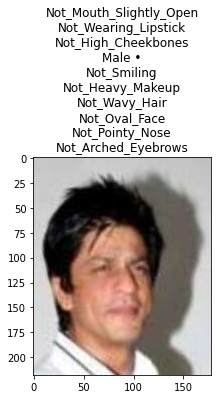

In [46]:
#@title Select Attributes {form-width: "50%", display-mode: "both" }

#NUMBER_OF_ATTRIBUTES = "10" #@param [0, 2, 10, 12, 40]
#N_ATTRIBUTES = int(NUMBER_OF_ATTRIBUTES)

IMAGE_RANGE = '11'

BATCH_SIZE =  64 #@param {type: "number"}
if N_ATTRIBUTES == 2:
    LABELS = ["Male", "Smiling"]

elif N_ATTRIBUTES == 10:
    LABELS = [
          "Mouth_Slightly_Open", "Wearing_Lipstick", "High_Cheekbones", "Male", "Smiling", 
          "Heavy_Makeup", "Wavy_Hair", "Oval_Face", "Pointy_Nose", "Arched_Eyebrows"]

elif N_ATTRIBUTES == 12:
    LABELS = ['Wearing_Lipstick','Mouth_Slightly_Open','Male','Smiling',
              'High_Cheekbones','Heavy_Makeup','Attractive','Young',
              'No_Beard','Black_Hair','Arched_Eyebrows','Big_Nose']
elif N_ATTRIBUTES == 40:
    LABELS = [
            '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
            'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
            'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows',
            'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
            'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open',
            'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
            'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns',
            'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
            'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace',
            'Wearing_Necktie', 'Young']

else:
    LABELS = ["Male", "Smiling"]# just for dataset creation
 

# Take labels and a list of image locations in memory
df = pd.read_csv(r"/content/celeba_gan/list_attr_celeba01.csv")
im_list = df['image_id'].tolist()


# load image at exact resolution
dataset_train = keras.preprocessing.image_dataset_from_directory(
    "celeba_gan", label_mode="int", 
    labels = df[LABELS].values.tolist(),
    image_size=(218, 178), 
    batch_size=BATCH_SIZE,
    seed=SEED)


def preprocess(dataset):
    # extract the center crop
    if IMAGE_SIZE == 64:
        dataset = dataset.map(lambda x,y: (crop128(x),y) )
        # resize
        dataset = dataset.map(lambda x,y: (resize64(x),y) )
    # convert image range
    dataset = dataset.map(lambda x,y: (conv_range([0,255], [-1,1])(x),y) )
    return dataset

dataset_train = preprocess(dataset_train)

if N_ATTRIBUTES !=0: 
    batch_img, batch_labels = next(iter(dataset_train))
    plt.title('\n'.join([(1-label)*'Not_'+LABELS[i]+' •'*int(label) for i,label in enumerate(batch_labels[0])]))

else: # remove labels
    dataset_train = dataset_train.map(lambda x,y: x)
    dataset_val = dataset_val.map(lambda x,y: x)
    batch_img = next(iter(dataset_train))
    
plt.imshow(batch_img[0].numpy()/2+0.5)

print("image in range: ", np.min(batch_img), np.max(batch_img))

# Evaluation

## Multi epochs

In [47]:
EPOCH_RANGE = range(8,15)
FID_COUNT = 10000


models = []
for i in EPOCH_RANGE:

    artifact_run = run_name +':v'+str(i)

    artifact = run.use_artifact(artifact_run, type='model')
    artifact_dir = artifact.download()
    gan = keras.models.load_model(os.path.join(artifact_dir, model_name + experiment_name))
    models.append(gan)

wandb: Downloading large artifact acgan10_nonseparBNstdev_split_299_218x178acgan10_nonseparBNstdev_split_299_218x178:v8, 474.61MB. 4 files... Done. 0:0:0
wandb: Downloading large artifact acgan10_nonseparBNstdev_split_299_218x178acgan10_nonseparBNstdev_split_299_218x178:v9, 474.61MB. 4 files... Done. 0:0:0
wandb: Downloading large artifact acgan10_nonseparBNstdev_split_299_218x178acgan10_nonseparBNstdev_split_299_218x178:v10, 474.61MB. 4 files... Done. 0:0:0
wandb: Downloading large artifact acgan10_nonseparBNstdev_split_299_218x178acgan10_nonseparBNstdev_split_299_218x178:v11, 474.61MB. 4 files... Done. 0:0:0
wandb: Downloading large artifact acgan10_nonseparBNstdev_split_299_218x178acgan10_nonseparBNstdev_split_299_218x178:v12, 474.61MB. 4 files... Done. 0:0:0
wandb: Downloading large artifact acgan10_nonseparBNstdev_split_299_218x178acgan10_nonseparBNstdev_split_299_218x178:v13, 474.61MB. 4 files... Done. 0:0:0
wandb: Downloading large artifact acgan10_nonseparBNstdev_split_299_218x

In [52]:
#@title Load Multilabel Classifier Model{form-width: "35%", display-mode: "both" }

#refactor to attribute accuracy logger
ENABLE_LOAD = True #@param {type:"boolean"}
SELECT_MODEL = 'weighted' #@param ['weighted']

import tensorflow.keras.backend as K


def f1_metric_logits(y_true, y_pred):
    y_pred = K.round(keras.activations.sigmoid(y_pred))
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)


def f1_metric(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def weighted_bce_from_logits(y_true, y_pred):

    #inverted_frequency weighting
    pos_weight= (1-attribute_frequency)*2
    y_true = tf.cast(y_true,'float32')
    bce = tf.nn.weighted_cross_entropy_with_logits(y_true, y_pred, pos_weight=pos_weight)
    #weighted_bce = attribute_frequency*(1-y_true) *bce
    #print(bce, weighted_bce)
    return K.mean(bce,axis=-1)


custom_objects = {'f1_metric': f1_metric, 
                  'f1_metric_logits': f1_metric_logits,
                  'weighted_bce_from_logits': weighted_bce_from_logits}

if IMAGE_SIZE == 64:
    if N_ATTRIBUTES == 2:

        if SELECT_MODEL == 0:
            resume_id = "2hxg7lvr"
            model_name = experiment_name = "mobilenet_2attr"
        elif SELECT_MODEL == 'weighted':
            resume_id = "    '2ckbukxu'"
            model_name = experiment_name = "mobilenet_2attr_weighted"

    elif N_ATTRIBUTES == 10:
        if SELECT_MODEL == 0:
            resume_id = "3pxaxlw4"
            model_name = experiment_name = "mobilenet_10attr"
        elif SELECT_MODEL == 'bce':
            resume_id = "20lo0dtn"
            model_name = experiment_name = "mobilenet_10attr_crossentropy"
        elif SELECT_MODEL == 'weighted':
            resume_id = "1ciqd5nw"
            model_name = experiment_name = "mobilenet_10attr_weighted"

    elif N_ATTRIBUTES == 40:
        if SELECT_MODEL == 0:
            resume_id = "joo3ui3c"
            model_name = experiment_name = "mobilenet_40attr"
        elif SELECT_MODEL == 'weighted':
            resume_id = "123ijj97"
            model_name = experiment_name = "mobilenet_40attr_weighted"

elif IMAGE_SIZE == 218:
    if N_ATTRIBUTES == 2:
        if SELECT_MODEL == 'weighted':
            resume_id = '3b15ld8p'
            model_name = experiment_name = "mobilenet_2attr_218x178_weighted"

    elif N_ATTRIBUTES == 10:
        if SELECT_MODEL == 'weighted':
            resume_id = "3n56eda3"
            model_name = experiment_name = "mobilenet_10attr_218x178_weighted"
    
    elif N_ATTRIBUTES == 40:
        if SELECT_MODEL == 'weighted':
            resume_id = "zd9xh3kq"
            model_name = experiment_name = "mobilenet_40attr_218x178_weighted"
   
else:
    print("N_ATTRIBUTES=", N_ATTRIBUTES, "skipping classifier load")
    ENABLE_LOAD = False


if ENABLE_LOAD:
    project_name = "GAN"
    !pip install wandb > /dev/null
    !wandb login
    import wandb
    from wandb.keras import WandbCallback
    run = wandb.init(project=project_name, 
                     name=experiment_name, 
                     resume=resume_id)

    run_name = 'buio/GAN/'+ model_name
    artifact_run = run_name +':latest'

    artifact = run.use_artifact(artifact_run, type='model')
    artifact_dir = artifact.download()
    attribute_classifier = tf.keras.models.load_model(os.path.join(artifact_dir, model_name),
                                                      custom_objects=custom_objects)

    attribute_classifier.compile(loss=keras.losses.BinaryCrossentropy(), metrics='binary_accuracy')
    #loss, gen_attr_accuracy = attribute_classifier.evaluate(dataset_df)
    #gen_attr_accuracy

    run.finish()


wandb: Currently logged in as: buio (use `wandb login --relogin` to force relogin)


FID,73.25191
attr_acc,0.91096
attr_f1_score,0
d_loss,0.53215
d_loss_attr,0.2591
d_loss_realfake,0.31967
epoch,13
g_loss,2.96433
g_loss_attr,0.42664
g_loss_realfake,2.71075


wandb: Downloading large artifact mobilenet_10attr_218x178_weighted:latest, 61.66MB. 8 files... Done. 0:0:0


best_epoch,3
best_val_loss,0.29821
binary_accuracy,0.89262
epoch,4
f1_metric_logits,0.82984
loss,0.27211
val_binary_accuracy,0.88242
val_f1_metric_logits,0.81414
val_loss,0.29822


## Evaluate Model

In [53]:
FID_COUNT = 10000
train_embeddings, train_attr = generate_dataset_embeddings(dataset_train, FID_COUNT)

In [54]:
def compute_metrics(gan_model):
    gen_embeddings, pred_attr = generate_fid_embeddings(gan_model, train_attr, FID_COUNT, use_attributes=True)
    fid = compute_fid(train_embeddings, gen_embeddings)
    acc = np.mean(tf.keras.metrics.binary_accuracy(train_attr[:FID_COUNT], pred_attr[:FID_COUNT]))
    f1 = f1_metric_logits(train_attr[:FID_COUNT], pred_attr[:FID_COUNT])
    metrics = {'fid':fid, 'f1':f1.numpy(), 'acc':acc}
    print(metrics)
    return metrics


## Evaluate per epoch

In [55]:
for epoch,gan in zip(EPOCH_RANGE, models):
    print("Epoch:",epoch)
    compute_metrics(gan)

Epoch: 8
using classifier


  0%|          | 0/100 [00:00<?, ?it/s]

computing FID on: (10000, 2048) (10000, 2048)
fid: 77.86116320210243 ssdiff: 25.55281 trace: 52.30835253315712
{'fid': 77.86116320210243, 'f1': 0.7057289, 'acc': 0.81945}
Epoch: 9
using classifier


  0%|          | 0/100 [00:00<?, ?it/s]

computing FID on: (10000, 2048) (10000, 2048)
fid: 78.36487079911812 ssdiff: 26.363764 trace: 52.00110698991402
{'fid': 78.36487079911812, 'f1': 0.71878576, 'acc': 0.81988996}
Epoch: 10
using classifier


  0%|          | 0/100 [00:00<?, ?it/s]

computing FID on: (10000, 2048) (10000, 2048)
fid: 64.86787139224565 ssdiff: 17.938934 trace: 46.92893706607377
{'fid': 64.86787139224565, 'f1': 0.7203602, 'acc': 0.83037996}
Epoch: 11
using classifier


  0%|          | 0/100 [00:00<?, ?it/s]

computing FID on: (10000, 2048) (10000, 2048)
fid: 71.37722347382787 ssdiff: 21.88015 trace: 49.497073632519275
{'fid': 71.37722347382787, 'f1': 0.7350771, 'acc': 0.83765}
Epoch: 12
using classifier


  0%|          | 0/100 [00:00<?, ?it/s]

computing FID on: (10000, 2048) (10000, 2048)
fid: 68.52466016735252 ssdiff: 20.619705 trace: 47.90495496715721
{'fid': 68.52466016735252, 'f1': 0.7405726, 'acc': 0.8434}
Epoch: 13
using classifier


  0%|          | 0/100 [00:00<?, ?it/s]

computing FID on: (10000, 2048) (10000, 2048)
fid: 69.0178558397465 ssdiff: 21.264175 trace: 47.75368042470744
{'fid': 69.0178558397465, 'f1': 0.74209106, 'acc': 0.83635}
Epoch: 14
using classifier


  0%|          | 0/100 [00:00<?, ?it/s]

computing FID on: (10000, 2048) (10000, 2048)
fid: 67.94824773565803 ssdiff: 20.088682 trace: 47.85956556097541
{'fid': 67.94824773565803, 'f1': 0.75031203, 'acc': 0.84453994}


# 📱📱 📲Weight Average

In [56]:
gen_weights = []
#select epochs to average by slicing
for gan in models[2:]:
    gen_weights.append(gan.generator.get_weights())

avg_weights = list()

for weights_list_tuple in zip(*gen_weights):
    avg_weights.append(
        np.array([np.array(weights).mean(axis=0) 
        for weights in zip(*weights_list_tuple)]))
    

avg_gan = gan
avg_gan.generator.set_weights(avg_weights)

In [57]:
compute_metrics(avg_gan)

using classifier


  0%|          | 0/100 [00:00<?, ?it/s]

computing FID on: (10000, 2048) (10000, 2048)
fid: 54.777108430127825 ssdiff: 12.390423 trace: 42.3866856090829
{'fid': 54.777108430127825, 'f1': 0.7596557, 'acc': 0.84474003}


{'acc': 0.84474003, 'f1': 0.7596557, 'fid': 54.777108430127825}

# 📸 Pretty plot images

### SAME NOISE DIFFERENT LABEL

In [ ]:
if N_ATTRIBUTES == 2:
    n = tf.random.truncated_normal(shape=(100,))
    b = tf.random.truncated_normal(shape=(100,))
    noise = np.array(tf.concat([[n for i in range(4)],[b for i in range(4)]], axis = 0))

if N_ATTRIBUTES == 10 or N_ATTRIBUTES == 40:
    n = tf.random.truncated_normal(shape=(100,))
    noise = np.array([n for _ in range(8)])
print(noise.shape)

(8, 100)


In [ ]:
if N_ATTRIBUTES == 2:
    attr = np.array([[0,0],[0,1],[1,0],[1,1], [0,0],[0,1],[1,0],[1,1]])
    
if N_ATTRIBUTES == 10:
    attr = np.array([[0,0,0,1,1,0,0,0,1,0],                     ## man, smile, nose, cheeck
                     [0,0,0,1,0,0,0,0,1,0],                              ## man, nose, cheek
                     [1,0,0,1,1,0,1,0,1,0],                              ## man, smile, nose, cheek, wavy
                     [1,0,0,1,0,0,1,0,1,0],                              ## man, nose, cheek
                     [0,0,0,0,1,0,0,0,1,0],                              ## smile, nose, cheek
                     [0,0,0,0,0,0,0,0,1,0],                              ## nose, cheek
                     [1,0,0,0,1,0,1,0,1,0],                              ## smile, nose, cheek, wavy
                     [1,0,0,0,0,0,1,0,1,0]])                             ## cheek, nose, lipstick, makeup
if N_ATTRIBUTES == 40:
    attr = np.array([[0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1],                     ## man, smile, nose, cheeck
                     [0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1],                            ## man, nose, cheek
                     [0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0,1,0,1,0,0,0,0,0,1],                              ## man, smile, nose, cheek, wavy
                     [0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,1],                            ## man, nose, cheek
                     [0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1],                            ## smile, nose, cheek
                     [0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1],                            ## man, nose, cheek
                     [0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,1,0,1,0,0,0,0,0,1],                            ## smile, nose, cheek, wavy
                     [0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,1]])
attr.shape


(8, 40)

### DIFFERENT NOISE SAME LABEL

In [ ]:
noise = tf.random.truncated_normal(shape=(8,100))

In [ ]:
if N_ATTRIBUTES == 2:
    attr = np.array([[0,1]]*8)

if N_ATTRIBUTES == 10:
    attr = np.array([[0,0,0,1,1,0,0,0,1,0]]*8)
                     
if N_ATTRIBUTES == 40:
    attr = np.array([[0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1]]*8)

### PLOT

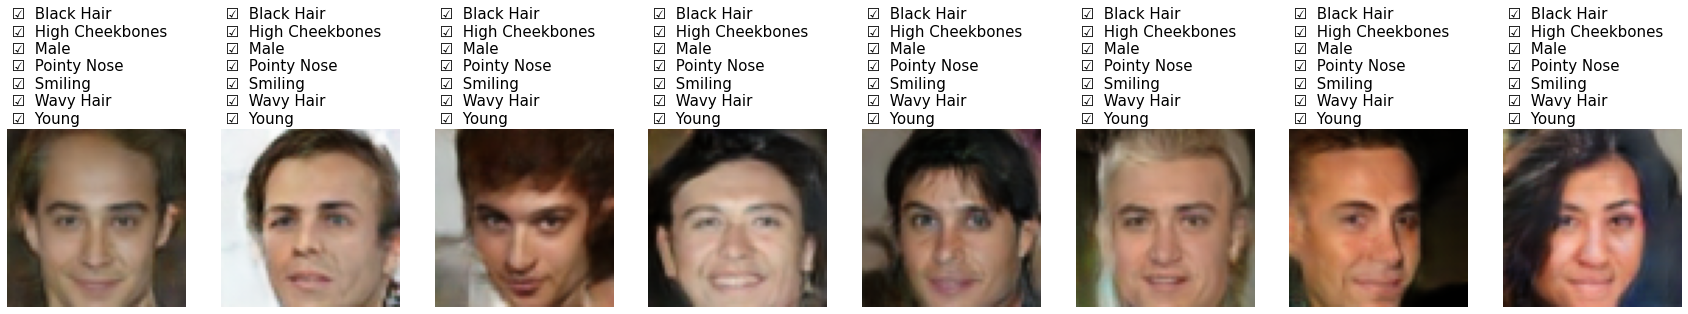

In [ ]:
num_img = 8
print_rows = 1

RANDOM_GEN = False

for i in range(1):
    if RANDOM_GEN:
        random_latent_vectors = tf.random.truncated_normal(shape=(num_img, LATENT_DIM))

        if N_ATTRIBUTES !=0:
            attr = np.array([attr_list[i] for i in np.random.randint(0,202600, num_img)])
            generated_images = gan.generator((random_latent_vectors, attr))
        else:
            generated_images = gan.generator(random_latent_vectors)
    else:
        generated_images = gan.generator((noise, attr))

    generated_images.numpy()
    generated_images = conv_range((-1,1), (0,1))(generated_images)

    fig, axes = plt.subplots(print_rows, num_img//print_rows, figsize=(30,20))
    #titfont = {'fontname':'Monospace'}
    
    for m, axis in enumerate(axes):
        axis.axis('off')
        axis.set_title('\n'.join([' ☑  '+label*' '.join(LABELS[i].split('_')) for i,label in enumerate(attr[m]) if label]),loc='left',fontsize=15)
            
        axis.imshow(generated_images[m])
    plt.show()